# QSHE
The center is MTI(Δ≠0) ,and the leads are EG.

c:\Users\23253\miniforge3\envs\xxy\lib\site-packages\kwant\_plotter.py:77: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  warnings.warn("plotly is not available, if other engines are unavailable,"


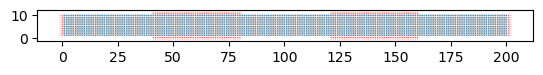

In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import tinyarray

sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

I_4= tinyarray.array(np.kron(sigma_0, sigma_0))
gamma_1 = tinyarray.array(np.kron(sigma_0, sigma_z))
gamma_2 = tinyarray.array(np.kron(sigma_z, sigma_z))
gamma_3 = tinyarray.array(np.kron(sigma_0, sigma_y))
gamma_4 = tinyarray.array(np.kron(sigma_0, sigma_x))

B=-300
g=300
D= -20 
las=1

structure=kwant.lattice.square(las, norbs=4)
model_sym= kwant.TranslationalSymmetry(structure.vec((-1,0)),structure.vec((0,-1)))

def onsite(site,m):
    return m/2*gamma_1 - (4*B)/las**2 * gamma_2 + D * gamma_2

hopping_x = B/(las**2)*gamma_2 + 1j*g/(2*las)*gamma_3
hopping_y = B/(las**2)*gamma_2 - 1j*g/(2*las)*gamma_4

def model_MTI():
    model_1= kwant.Builder(model_sym)

    model_1[structure(0, 0)] = onsite
    model_1[kwant.builder.HoppingKind((1,0), structure)]  = hopping_x
    model_1[kwant.builder.HoppingKind((0,1), structure)]  = hopping_y

    return model_1

def model_EG():

    onsite_leads= 150 *I_4
    hopping_leads= -150 *I_4

    model_2= kwant.Builder(model_sym)
    model_2[structure(0, 0)] = onsite_leads
    model_2[structure.neighbors()]  = hopping_leads

    return model_2

def make_syst(width=50,length=100,leads_model=model_EG()):
    
    ########### create the scattering center

    def shape_center(site):
        x, y = site.pos
        return 0 < x <= length and 0 < y <= width

    syst= kwant.Builder()
    syst.fill(model_MTI(), shape_center,(1,1))

    ########### create the leads

    width_lead = length//5

    lead0= kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    lead1= kwant.Builder(kwant.TranslationalSymmetry((0,1)))
    lead2= kwant.Builder(kwant.TranslationalSymmetry((0,1)))

    def shape_lead0(site):
        x, y = site.pos
        return 0 < y <= width

    def shape_lead1(site):
        x, y = site.pos
        return width_lead < x <= 2*width_lead

    def shape_lead2(site):
        x, y = site.pos
        return 3*width_lead < x <= 4*width_lead

    lead0.fill(leads_model, shape_lead0, (0, 1))
    lead1.fill(leads_model, shape_lead1, (width_lead+1, 0))
    lead2.fill(leads_model, shape_lead2, (3*width_lead+1, 0))

    ########### create the six-terminal device
    for lead in [lead0,lead1,lead2, lead0.reversed(),lead2.reversed(),lead1.reversed()]:
        syst.attach_lead(lead)

    return syst.finalized()

syst1=make_syst(width=10,length=200,leads_model=model_MTI())
kwant.plot(syst1);

## Band structure

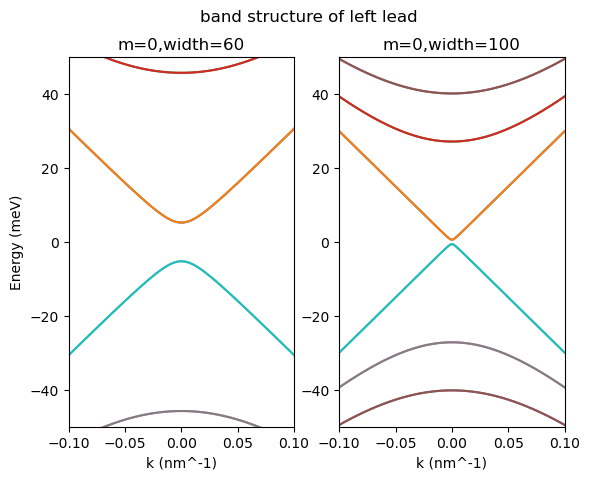

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.suptitle('band structure of left lead')

x_lim=0.1
y_lim=50
ax1.set_ylabel('Energy (meV)')
ax1.set_title('m=0,width=60')
ax2.set_title('m=0,width=100')
for ax in (ax1,ax2):
    ax.set_xlabel('k (nm^-1)')
    ax.set_ylim(-y_lim,y_lim)
    ax.set_xlim(-x_lim,x_lim)

syst1=make_syst(width=30,leads_model=model_MTI()).leads[0]
syst2=make_syst(width=60,leads_model=model_MTI()).leads[0]
  
kwant.plotter.bands(syst1,momenta=np.linspace(-x_lim, x_lim, 100), ax=ax1, params=dict(m=0));
kwant.plotter.bands(syst2,momenta=np.linspace(-x_lim, x_lim, 100), ax=ax2, params=dict(m=0));


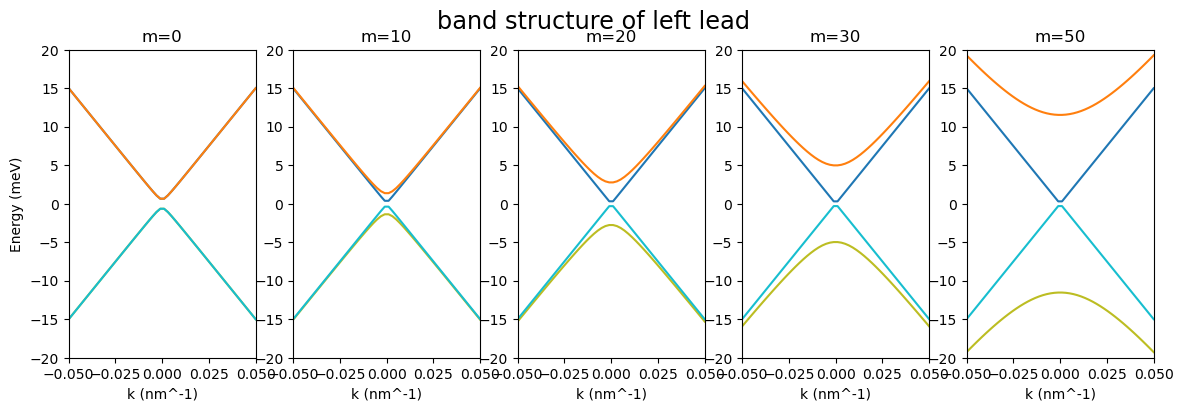

In [5]:
syst1=make_syst(width=60,length=300,leads_model=model_MTI()).leads[0]

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(14, 4))
fig.suptitle('band structure of left lead', size='xx-large')
y_limit = 20
x_limit = 0.05
ax1.set_ylabel('Energy (meV)')
for ax in zip((ax1,ax2,ax3,ax4,ax5),(0,10,20,30,50)):
    ax[0].set_xlabel('k (nm^-1)')
    ax[0].set_ylim(-y_limit,y_limit)
    ax[0].set_xlim(-x_limit,x_limit)
    ax[0].set_title(f'm={ax[1]}')
    kwant.plotter.bands(syst1,momenta=np.linspace(-x_limit,x_limit , 50), ax=ax[0], params=dict(m=ax[1]));


When m is 30, the two bands inside will never overlap no matter what, so we will never observe the QSHE.

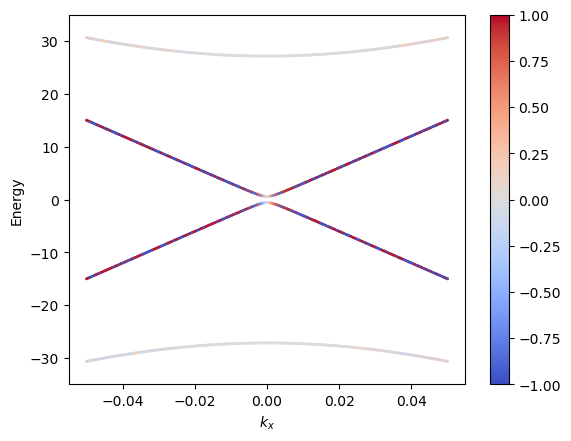

In [ ]:
syst1=make_syst(width=60,length=300,leads_model=model_MTI()).leads[0]

bands = kwant.physics.Bands(syst1, params=dict(m=0))
momenta=np.linspace(-0.05, 0.05, 200)

#es存放本征值，evs存放本征矢量
es=[] 
evs=[]
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b)

#这部分代码的目的是为能带图上的每一个点计算一个颜色值
zcolors=[]
for k in range(len(momenta)):  #某一个确定的k，例如9.8
    tem_1=[]
    for i in range(np.array(es).shape[1]):  #输出列数，比如i=2
            swf=np.reshape(np.abs(evs[k][:,i])**2,(-1,2)).sum(1)
            tem_c=swf.reshape(2,-1).sum(1)
            tem_1.append(tem_c[0]-tem_c[1])
    zcolors.append(tem_1)    

for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.ylim(-35,35)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

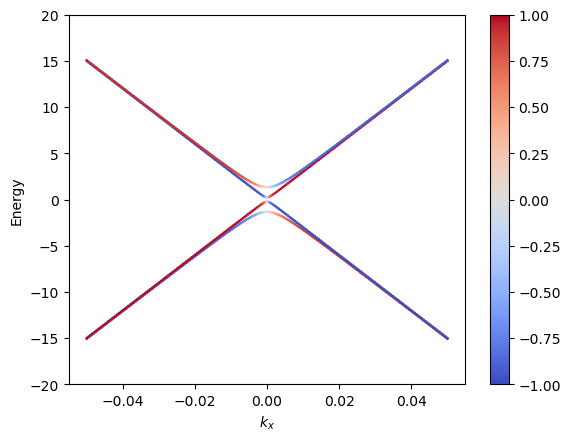

In [ ]:
syst=make_syst(width=60,length=300,leads_model=model_MTI()).leads[0]

bands = kwant.physics.Bands(syst, params=dict(m=10))
momenta=np.linspace(-0.05, 0.05, 200)

es=[]
evs=[]
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b)

zcolors=[]
for k in range(len(momenta)):               # 某一个确定的k，例如9.8
    tem_1=[]
    for i in range(np.array(es).shape[1]):  # 输出列数，比如i=2
            swf=np.reshape(np.abs(evs[k][:,i])**2,(-1,2)).sum(1)
            tem_c=swf.reshape(2,-1).sum(1)
            tem_1.append(tem_c[0]-tem_c[1])
    zcolors.append(tem_1)      

for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.ylim(-20,20)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

## Density of current

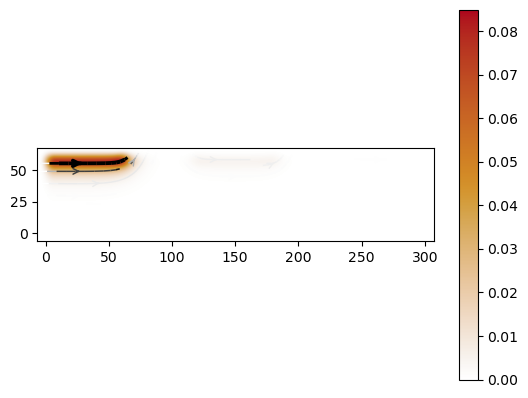

In [2]:
fsyst = make_syst(width=60,length=300,leads_model=model_MTI())

J=kwant.operator.Current(fsyst)                              # J算符的用法：须由指定的系统fsyst定义，当我作用一个指定的波函数时，它可以给出波函数在散射中心的电流分布。
wf=kwant.wave_function(fsyst, energy=0.5,params=dict(m=10))  # 给出了在该能量下能够使用的通道集合，即所有可能入射的波函数的集合。
psi=wf(0)[0]                                                 # (0)第一个引线，[0]第一个通道。能量从低到高排序。 #psi指定了波函数。                           
current = J(psi)
kwant.plotter.current(fsyst, current, colorbar=True, show=True)

--- 正在分析能量 E = 0.5 (m = 10) 时的引线通道 ---
  引线 0: 2 个可用通道 (传播模式)
  引线 1: 2 个可用通道 (传播模式)
  引线 2: 2 个可用通道 (传播模式)
  引线 3: 2 个可用通道 (传播模式)
  引线 4: 2 个可用通道 (传播模式)
  引线 5: 2 个可用通道 (传播模式)
--- 通道分析完毕 ---

正在选择入射波函数：来自引线 0，通道 0...
正在计算电流分布...
正在绘制电流图...


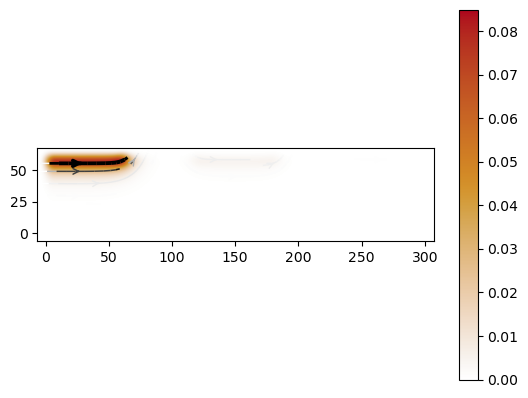

In [3]:
fsyst = make_syst(width=60, length=300, leads_model=model_MTI())

energy_val = 0.5
m_value = 10

print(f"--- 正在分析能量 E = {energy_val} (m = {m_value}) 时的引线通道 ---")
if 'fsyst' in locals():
    for i, lead in enumerate(fsyst.leads):
        modes = lead.modes(energy=energy_val, params=dict(m=m_value))
        num_channels = modes[0].wave_functions.shape[1]
        print(f"  引线 {i}: {num_channels} 个可用通道 (传播模式)")
    print("--- 通道分析完毕 ---\n")
else:
    print("错误：系统 'fsyst' 未被创建，无法分析通道。")

J = kwant.operator.Current(fsyst)
wf = kwant.wave_function(fsyst, energy=energy_val, params=dict(m=m_value))

print("正在选择入射波函数：来自引线 0，通道 0...")
psi = wf(0)[0]

print("正在计算电流分布...")
current = J(psi)

print("正在绘制电流图...")
kwant.plotter.current(fsyst, current, colorbar=True, show=True)

## Distribution of wavefuncion

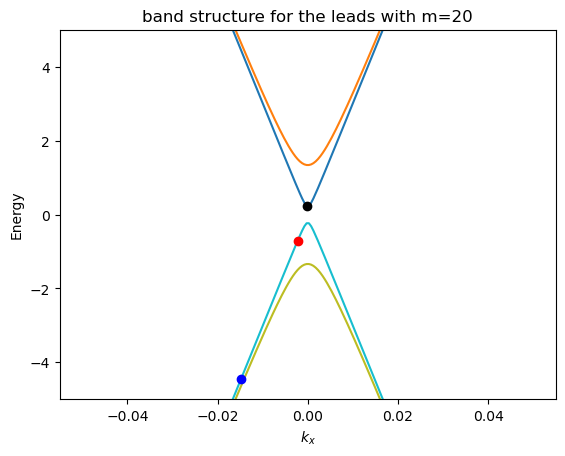

In [15]:
syst1=make_syst(width=60,length=300,leads_model=model_MTI()).leads[0]

bands = kwant.physics.Bands(syst1, params=dict(m=10))
momenta=np.linspace(-0.05, 0.05, 200)

es=[]
evs=[]
for k in momenta:
    tem_a,tem_b= bands(k=k,return_eigenvectors = True) 
    es.append(tem_a)
    evs.append(tem_b)

# the 100th, 96th and 70th states (k values) are chosen, the 120th energy level (band) is chosen
plt.plot(momenta,es);
plt.plot(momenta[99], es[99][120], 'ko')
plt.plot(momenta[95], es[95][119], 'ro')
plt.plot(momenta[70], es[70][119], 'bo')
plt.ylim(-5,5)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.title('band structure for the leads with m=20');

Text(0, 0.5, 'possibility of the wavefunction')

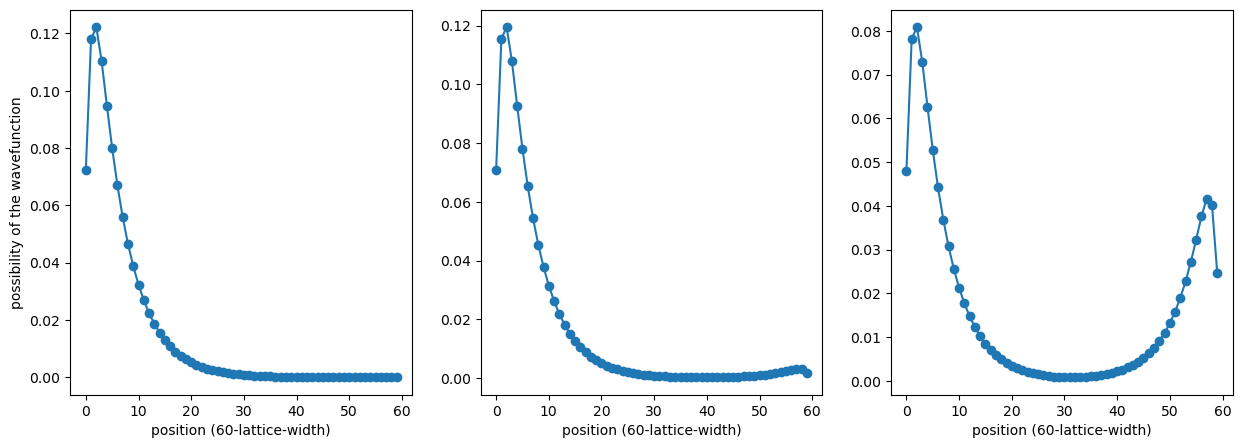

In [ ]:
swf1=np.abs(evs[70][:,119])**2
swf2=np.abs(evs[95][:,119])**2
swf3=np.abs(evs[99][:,119])**2
fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(15,5))
ax1.plot(range(60),swf1.reshape((-1,4)).sum(1),'-o')
ax2.plot(range(60),swf2.reshape((-1,4)).sum(1),'-o')
ax3.plot(range(60),swf3.reshape((-1,4)).sum(1),'-o')

for ax in (ax1,ax2,ax3):
    ax.set_xlabel('position (60-lattice-width)')
ax1.set_ylabel('possibility of the wavefunction')

#可以看出传输模式的波函数集中在边缘

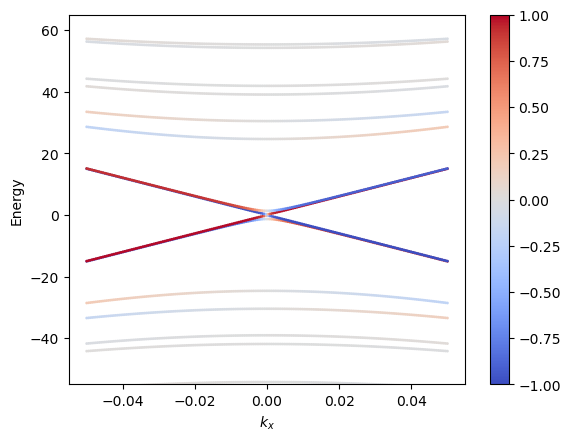

In [9]:
zcolors=[]
for k in range(len(momenta)):
    tem_1=[]
    for i in range(np.array(es).shape[1]):
            swf=np.reshape(np.abs(evs[k][:,i])**2,(-1,2)).sum(1)
            tem_c=swf.reshape(2,-1).sum(1)
            tem_1.append(tem_c[0]-tem_c[1])
    zcolors.append(tem_1)

    
#1
for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.ylim(-55,65)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

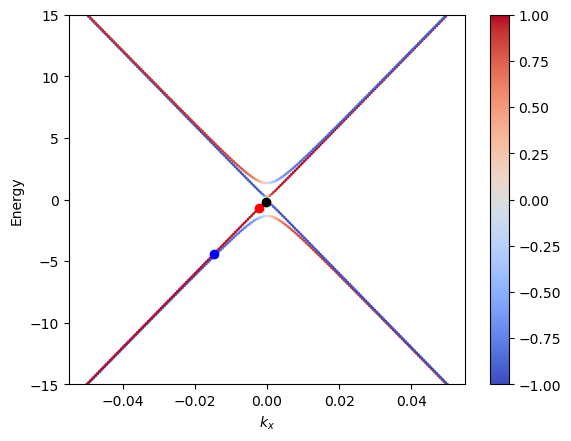

In [10]:
#1.1
for i in range(np.array(es).shape[1]):
    plt.scatter(momenta,np.array(es)[:,i],s=1,c=np.array(zcolors)[:,i],cmap="coolwarm",vmin=-1.,vmax=1.)
plt.plot(momenta[70], es[70][119], 'bo')
plt.plot(momenta[95], es[95][119], 'ro')
plt.plot(momenta[99], es[99][119], 'ko')
plt.ylim(-15,15)
plt.xlabel('$k_x$')
plt.ylabel('Energy')
plt.colorbar();

## R

In [11]:
def find_voltages(tmatrix,current):
    try:
        voltage = np.linalg.solve(tmatrix[1:, 1:], current[1:])
    except np.linalg.LinAlgError as err:
        if 'Singular matrix' in str(err):
            print("Hi there, singular matrix here")
            voltage = [0,0,0,0,0]
        else:
            raise
    return [0, *voltage]

def resistance_xx(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
    
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]

    return resistance(2, 3)

def resistance_xy(tmatrix):
    current = [1, 0, 0, -1, 0, 0]
    voltage = find_voltages(tmatrix,current)
    
    def resistance(lead1, lead2):
        return voltage[lead1-1]-voltage[lead2-1]

    return resistance(2, 6)

def rMplot(m_list, data, ptitle='resistance vs m'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(m_list,rxx,'-o', label='$R_{xx}$')
    plt.plot(m_list,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()


# define a function to plot the resistance vs energy
# here, "data" is a "np.array", a list (different energy) of 6*6 transimission matrices=[]
def rEplot(energies, data, ptitle='resistance vs energy'):
    rxx=[]
    rxy=[]
    for i in range(data.shape[0]):
        rxx.append(resistance_xx(data[i]))
        rxy.append(resistance_xy(data[i]))

    plt.plot(energies,rxx,'-o', label='$R_{xx}$')
    plt.plot(energies,rxy,'-o', label='$R_{xy}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('Energy')
    plt.ylabel('Resistance')
    plt.legend()


## R vs E
Here we have data0 which records  T matrix for different E.

Hi there, singular matrix here
Hi there, singular matrix here


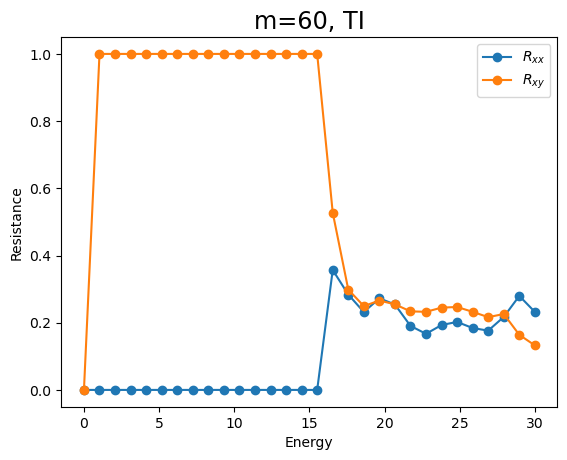

In [12]:
syst0=make_syst(width=60,length=300,leads_model=model_MTI())

data0=[]
e_range=np.linspace(0,30,num=30)
for energy in e_range:
    tmatrix = kwant.smatrix(syst0, energy,params=dict(m=60))
    data0.append(tmatrix.conductance_matrix())

rEplot(e_range,np.array(data0),"m=60, TI")    

In [13]:
np.round(data0[1],4)

array([[ 1., -0., -0., -0., -0., -1.],
       [-1.,  1., -0., -0., -0., -0.],
       [-0., -1.,  1., -0., -0., -0.],
       [-0., -0., -1.,  1., -0., -0.],
       [-0., -0., -0., -1.,  1., -0.],
       [-0., -0., -0., -0., -1.,  1.]])

Hi there, singular matrix here
Hi there, singular matrix here


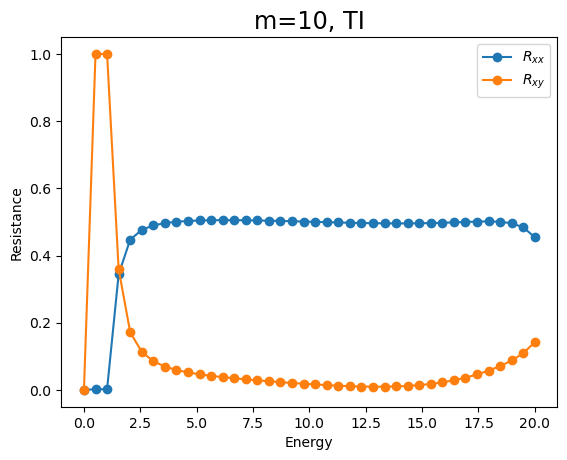

In [14]:
syst_A=make_syst(width=60,length=300,leads_model=model_MTI())

data=[]
e_range=np.linspace(0,20,num=40)
for energy in e_range:
    tmatrix = kwant.smatrix(syst_A, energy,params=dict(m=10))
    data.append(tmatrix.conductance_matrix())

rEplot(e_range,np.array(data),"m=10, TI")

Hi there, singular matrix here
Hi there, singular matrix here


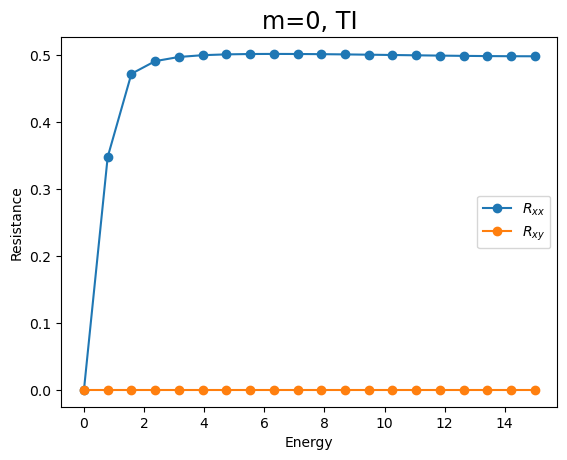

In [15]:
data=[]
e_range=np.linspace(0,15,num=20)
for energy in e_range:
    tmatrix = kwant.smatrix(syst_A, energy,params=dict(m=0))
    data.append(tmatrix.conductance_matrix())

rEplot(e_range,np.array(data),"m=0, TI")    

## R vs m

We first use the data to record the conductivity matrics at a specific E vakue for different values of m.

In [16]:
systm=make_syst(width=60,length=300,leads_model=model_MTI())

data=[]
m_range=np.linspace(-60,60,num=31)
for m_value in m_range:
    tmatrix = kwant.smatrix(systm, 10.0, params=dict(m=m_value))
    data.append(tmatrix.conductance_matrix())

In [17]:
np.round(data[1],2)

array([[ 1., -1., -0., -0., -0., -0.],
       [-0.,  1., -1., -0., -0., -0.],
       [-0., -0.,  1., -1., -0., -0.],
       [-0., -0., -0.,  1., -1., -0.],
       [-0., -0., -0., -0.,  1., -1.],
       [-1., -0., -0., -0., -0.,  1.]])

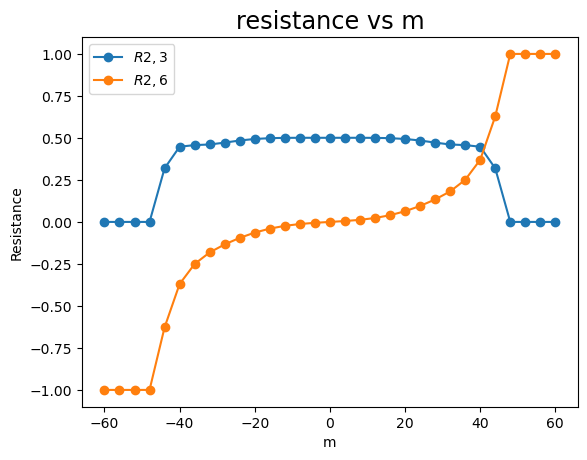

In [18]:
#任意端口
def rMplot_m(m_list, data, lead1=2,lead2=5, ptitle='resistance vs m'):
    current = [1, 0, 0, -1, 0, 0]
    rx=[]
    for i in range(data.shape[0]):
        voltage = find_voltages(data[i],current)
        rx.append(voltage[lead1-1]-voltage[lead2-1])

    plt.plot(m_list,rx,'-o', label=f'$R {lead1},{lead2}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()

rMplot_m(m_range,np.array(data),2,3)
rMplot_m(m_range,np.array(data),2,6)



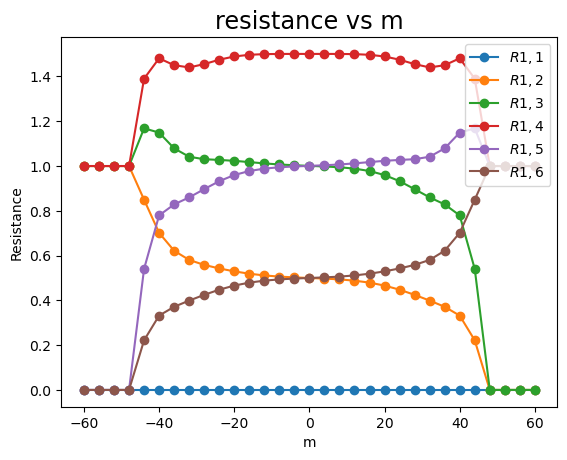

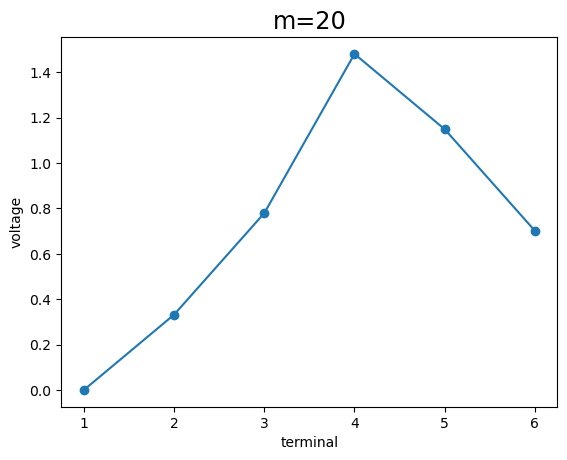

In [19]:
# One m, one resistance
r=[]
def rMplot_m_p(m_list, data, lead1=2,lead2=5, ptitle='resistance vs m'):
    current = [1, 0, 0, -1, 0, 0]
    rx=[]
    for i in range(data.shape[0]):
        voltage = find_voltages(data[i],current)
        rx.append(voltage[lead1-1]-voltage[lead2-1])
    r.append(rx[25])   
    plt.plot(m_list,rx,'-o', label=f'$R {lead1},{lead2}$')

    plt.title(ptitle, size='xx-large')
    plt.xlabel('m')
    plt.ylabel('Resistance')
    plt.legend()
# double 3
rMplot_m_p(m_range,np.array(data),1,1)
rMplot_m_p(m_range,np.array(data),1,2)
rMplot_m_p(m_range,np.array(data),1,3)
rMplot_m_p(m_range,np.array(data),1,4)
rMplot_m_p(m_range,np.array(data),1,5)
rMplot_m_p(m_range,np.array(data),1,6)
plt.show()

#voltage vs n
np.round(r,2)

plt.plot(range(1,7),r,'-o', label='R')
plt.title("m=20", size='xx-large')
plt.xlabel('terminal')
plt.ylabel('voltage')
plt.show()
